# Notebook use to test backend and tensorflow fonctionnalities

In [1]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import AE_Generator, Full_Diff_Generator, Basic_Generator, FLX_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch, F_and_plots, Plot_triple_diff_separated
from CST import CST

data_folder=  'Data3'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)
######
seed=0
batch_size=32
np.random.seed(seed)

def identity(x):
    return(x)

def Log(x): 
    return(np.log(1 - x + 0.1))

def Log(x): 
    return(np.log(1 - x + 0.1))# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import AE_Generator, Full_Diff_Generator, Basic_Generator, FLX_Generator, CloudyGenerator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch, F_and_plots, Plot_triple_diff_separated
from CST import CST

data_folder=  'Data3'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)
######
seed=0
batch_size=32
np.random.seed(seed)

def identity(x):
    return(x)

def Log(x): 
    return(np.log(1 - x + 0.1))

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Preproc

In [3]:
##### Kernels
D=[Load_FLX_dict('DictPrepross2.hdf5')]
def Bin(x): 
    x[np.where(x!=0)] = 1
#    x[np.where(x==0)] = 0
    return(x)

Klist0 = []
Klist =[]# FKernel(identity, ['ql']), FKernel(identity, ['qi']) ]

D2 = [DictPrepross(['o3','pl','q'], 
     [Level_Normalizer(False), Level_Normalizer(False), Level_Normalizer(False)] )]

# WARNING : NOT FIT ON THE SAME
fit_genator =FLX_Generator(folder=data_folder, batch_size=10*batch_size, chosen_var=['flxd', 'flxu'],
                                  train=True, preprocess_x=D+Klist0, custom_b_p_e=0)
fit_genator.max_b=50
D2[0].fitonGen(fit_genator, axis=2)
del(fit_genator)

In [4]:
# V
V = [VarSuppression(['ts', 'frocean', 'frlake','frland','frlandice', 'frseaice'])]

##### Full Preprocessing :
FP = D + Klist + D2 + V

##### b_size
train_generator =  FLX_Generator(folder=data_folder, batch_size=batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1)
validation_generator = FLX_Generator(folder='Data3', batch_size=batch_size, train=False, 
                                             preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0)
#cold_generator = Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)

header_x = train_generator.used_variables
header_y = train_generator.new_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

In [5]:
#train_generator._div = train_generator._div - 1
#train_generator.idx_file=np.arange(train_generator._div)
#validation_generator._div = 1
#validation_generator.idx_file=np.array([train_generator._div])

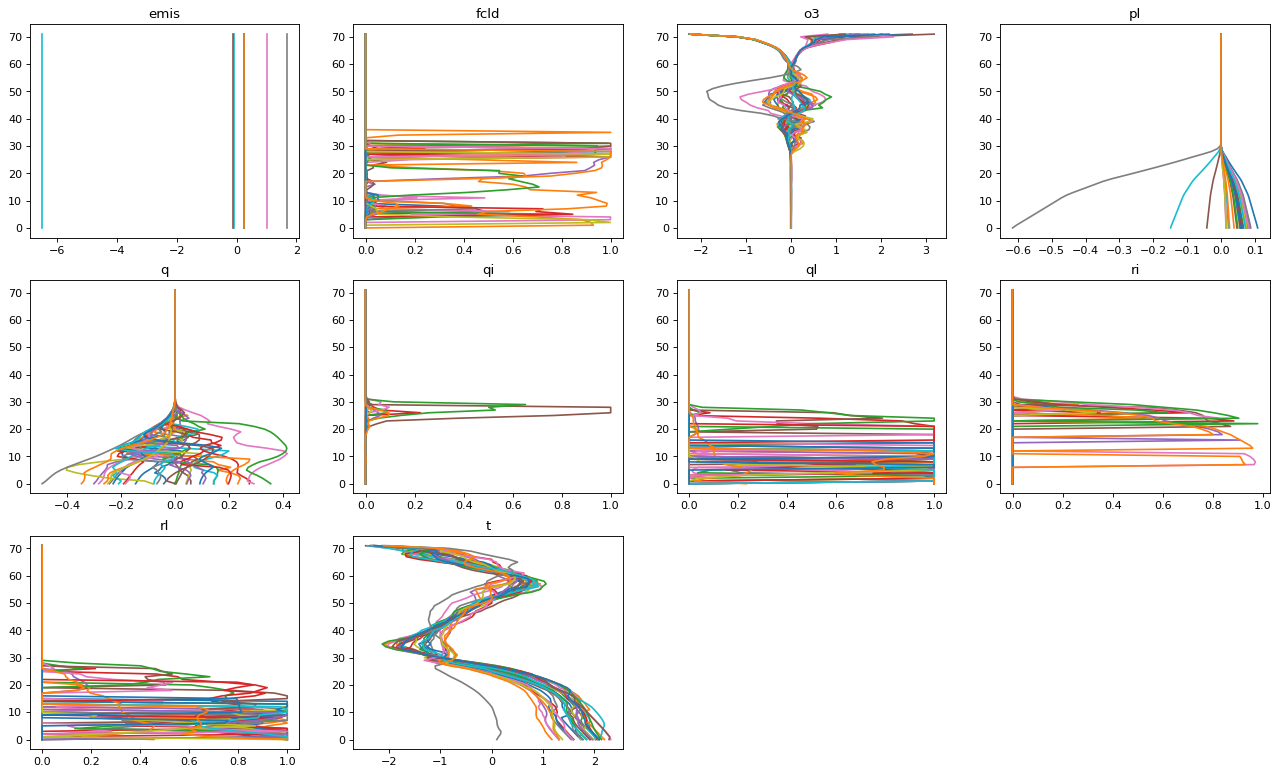

In [6]:
x,y = train_generator[0]
Plot_Batch(x,header_x)

In [7]:
import keras

from architectures import AE, Unet_Act_Double
from architectures_simples import Upsampler, Divide_Recombine, Divide_Substract
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Name
from keras.layers import Dense, Flatten, Reshape, Lambda, Input

import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

lev=72
reg=10e-5
list_of_filters_ae =  [[32, 64, 64, 128], 
                       [30, 30, 50, 50, 128, 128], 
                       [40, 10], 
                       [64, 64, 128, 128, 128, 128], 
                       [256, 32, 2]]

list_of_kernel_ae =  [[10, 10, 5, 5], 
                      [2, 5, 2, 5, 2, 4], 
                      [], 
                      [3, 4, 3, 5, 3, 6], 
                      [10, 5, 3]]

list_of_activations_ae =  [['elu', 'elu', 'elu', 'elu'], 
                            ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], 
                            ['tanh', 'tanh', 'tanh'], 
                            ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], 
                            ['elu', 'elu', 'linear']]

params_ae = [0.01]
M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_unet =  Unet_Act_Double(list_of_kernel_ae, list_of_filters_ae, list_of_activations_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=in_channel, reg=1e-7)
#M_f =Divide_Substract(o_channel, list_of_filters_ae[-1][-1], lev=lev,reg=1e-7)
#M_f.trainable = False

Sub_f = lambda x: x[:,:,0] - x[:,:,1]
Sub = keras.layers.Lambda(Sub_f)
#model = keras.Model(Input0, Sub)

M = keras.models.Sequential()
M.add(M_Up); M.layers[-1].name = 'Upsampler'
M.add(M_unet); M.layers[-1].name = 'Unet'
#M.add(M_f); M.layers[-1].name = 'Div_Rec'
M.add(Sub); M.layers[-1].name = 'Substract'
#M.add(Flatten())
M.summary()

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures_simples.py:27: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", strides=5)`
  Avg = AveragePooling1D(pooling, padding='same', stride=avg)(Up)
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_100", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_101", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `Av

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 10)            0         
_________________________________________________________________
Unet (Model)                 (None, 72, 2)             1336146   
_________________________________________________________________
Substract (Lambda)           (None, 72)                0         
Total params: 1,336,146
Trainable params: 1,336,146
Non-trainable params: 0
_________________________________________________________________


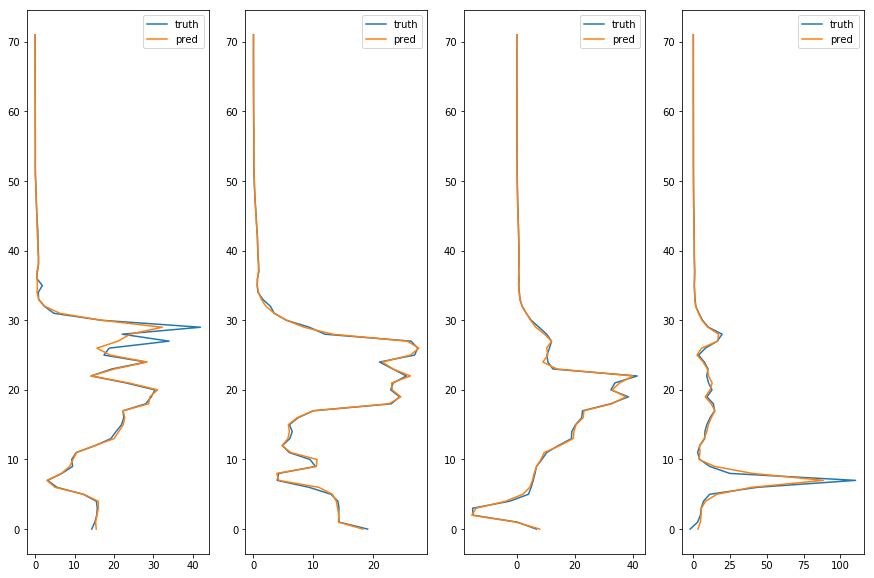

In [8]:
from utils import F_and_plots, Plot_diff, Jacobian, Sep_Var_Gradient, Sep_Var_show

M.load_weights('BestModels/Best_Unet_[double_output]_4epochs')
i=np.random.randint(len(validation_generator))
x,y=validation_generator[i]
y0 = M.predict(x)
y0 = np.expand_dims(y0,axis=-1)
y = np.expand_dims(y,axis=-1)
J=np.arange(4)
Plot_diff( F_and_plots(shape=(1,len(J))), y,y0, header_y=['flx'], J=J)

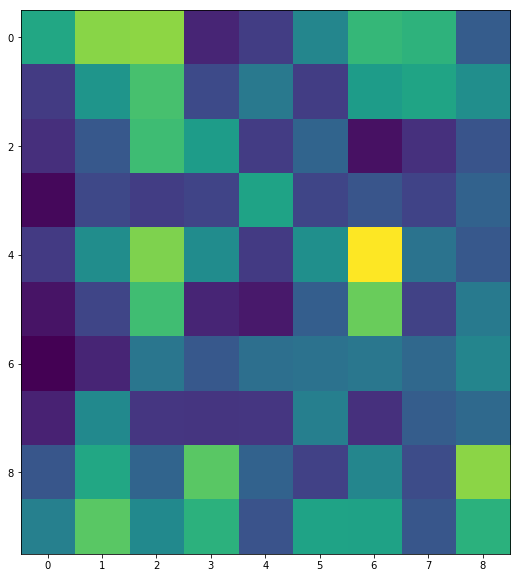

In [14]:
import tensorflow as tf
# CHECKING IMPACT OF LOWER LAYER
x,y = validation_generator[100]
y0 = M.predict(x)

i = M_Up.get_input_at(0)
o = M_Up.get_output_at(0)

Up_model = K.function([i],[o])

i1 = M_unet.get_input_at(0)
o1 = M_unet.get_output_at(0)

o_dense = M_unet.get_layer('Reshape').output
#o4 = M_unet.get_layer('Dense_1').get_output_at(0)
o_last = M_unet.get_layer('linear_302').get_output_at(0)

Second_model = K.function( [i1],[o1])
Dense_layer = K.function( [i1],[o_dense])
#Antepen_layer = K.function( [i1],[o3])
Last_layer = K.function( [i1],[o_last])


#img = Dense_layer(First_model([x]))[0]
img = Dense_layer( Up_model([x]))[0]

#Antepen_layer(Up_model([x]))[0]
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
ax.imshow((np.mean(abs(img),axis=0).T))
#F = K.function(I,O)
#F([tf.cast(x,tf.float32)])

In [20]:
W = M_unet.get_layer('Dense_1').get_weights()

[array([[-0.06215722, -0.05753477,  0.08414932, ...,  0.03079344,
         -0.00927654,  0.08177096],
        [-0.13490468, -0.08213685, -0.01703533, ..., -0.12673494,
          0.12370291,  0.07815779],
        [ 0.09584288, -0.15192775,  0.05167589, ..., -0.0131549 ,
          0.08988211,  0.01743164],
        ...,
        [ 0.10899863,  0.2732591 , -0.120822  , ...,  0.01924253,
         -0.08663063, -0.07195862],
        [ 0.10574417, -0.3402517 ,  0.1155886 , ...,  0.10699184,
          0.10084439, -0.10284425],
        [-0.16294461,  0.11797882, -0.04038763, ..., -0.05329202,
         -0.12811889, -0.08694504]], dtype=float32),
 array([-4.84294862e-01,  2.10033834e-01, -3.75322431e-01, -1.73007131e-01,
         3.73854011e-01, -4.88924049e-02, -5.36444187e-02, -1.91362649e-01,
        -3.72429848e-01, -4.23889190e-01, -4.48999792e-01,  3.23859990e-01,
        -2.64722615e-01, -3.38323742e-01,  4.62743312e-01, -1.62050769e-01,
        -2.18275357e-02, -2.82816321e-01, -3.82570863e

### OLD GRADIENT TEST

In [43]:
#gradients = K.gradients(modelbd.get_output_at(), modelbd.input)  
s = np.zeros((64,72,1))
x_test_1 = train_generator[0][0]

for i in range(10):
    print(i)
    
    gradients = K.gradients(modelbd.get_output_at(0)[:,i], modelbd.get_input_at(0)[:,:,10])
#    gradients = K.gradients(modelbd.get_output_at(0)[:,i], modelbd.get_input_at(0))
  
    #value of gradient for the first x_test
    #x_test_1 = x_test_1.reshape(1,72,11)
    sess = K.get_session()
    evaluated_gradients_1 = sess.run(gradients[0], feed_dict={modelbd.input: x_test_1})
    #print(evaluated_gradients_1)
    s+=evaluated_gradients_1;

gradients = K.gradients(modelbd.get_output_at(0), modelbd.input)
sess = K.get_session()
evaluated_gradients_1 = sess.run(gradients[0], feed_dict={modelbd.input: x_test_1})

0


AttributeError: Layer sequential_1 has multiple inbound nodes, hence the notion of "layer input" is ill-defined. Use `get_input_at(node_index)` instead.

In [6]:
# with all 72
print('Phase 2')
s2 = np.zeros((64,72, 1))
for i in range(10):
    gradients = K.gradients(model2.get_output_at(0)[:,i], model2.input)
    sess = K.get_session()
    ts = x_test_1[:,:,-1].reshape(x_test_1.shape[0], x_test_1.shape[1], 1 )
    t=time.time()
    evaluated_gradients_1 = sess.run(gradients[0], feed_dict={model2.input: ts})
    print(i, time.time()-t)
    s2+=evaluated_gradients_1;

NameError: name 'tf' is not defined

In [20]:
k_constants = K.constant(x_test_1[:,:,:-1])
input11 = keras.layers.Input(batch_shape=(64,1))
input12 = keras.layers.RepeatVector(n=72)(input11)
out11 = keras.layers.Lambda(lambda x: K.concatenate([x,k_constants],axis=-1))(input12)
out12 = modelbd(out11)
out13 = keras.layers.Lambda(lambda x: x[:,0])(out12)
model1 = keras.models.Model(inputs=input11, outputs=out13)
print(model1.summary())
#k_constants = K.constant(x_test_1[:,:,:-1])
input21 = keras.layers.Input(batch_shape=(64,72, 1))
#input12 = keras.layers.RepeatVector(n=72)(input11)
out21 = keras.layers.Lambda(lambda x: K.concatenate([x,k_constants],axis=-1))(input21)
out22 = modelbd(out21)
model2 = keras.models.Model(inputs=input21, outputs=out22)
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (64, 1)                   0         
_________________________________________________________________
repeat_vector_6 (RepeatVecto (64, 72, 1)               0         
_________________________________________________________________
lambda_10 (Lambda)           (64, 72, 11)              0         
_________________________________________________________________
sequential_1 (Sequential)    multiple                  273377    
_________________________________________________________________
lambda_11 (Lambda)           (64,)                     0         
Total params: 273,377
Trainable params: 273,377
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

In [5]:
x_test_1 = train_generator[0][0]
test_generator = Diff_Generator(folder=data_folder, batch_size=16, \
                                train=False, shuffle=True, preprocess_x=[D]+Klist, custom_b_p_e = 50)
x,y = test_generator[0]

In [16]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (64, 72, 1)               0         
_________________________________________________________________
lambda_7 (Lambda)            (64, 72, 11)              0         
_________________________________________________________________
sequential_3 (Sequential)    (64, 72, 1)               12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [83]:
from keras.layers import*
from keras.models import *
from keras import backend as K
import numpy as np

a = Input(shape=(10, 5), batch_shape=(16,10,5) )
a1 = Input(tensor=K.variable(np.ones((16, 10, 5))), batch_shape=(16,10,5))
x = [a, a1]  # x = [a, a] works fine
b = concatenate(x, 1)
x += [b]  # This changes b._keras_history[0].input
constant=K.variable(np.ones((16,10, 5)))
b = Lambda(lambda x: K.concatenate([x,constant],axis=1),output_shape=(20,5))(a)

model = Model(a, b)
model.summary()
x=model.predict(np.zeros((16,10,5)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        (16, 10, 5)               0         
_________________________________________________________________
lambda_7 (Lambda)            (16, 20, 5)               0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [23]:
len(train_generator)*32/1000000

2.985984

In [40]:
def map(f, x, dtype=None, parallel_iterations=10):
    '''
    Apply f to each of the elements in x using the specified number of parallel iterations.

    Important points:
    1. By "elements in x", we mean that we will be applying f to x[0],...x[tf.shape(x)[0]-1].
    2. The output size of f(x[i]) can be arbitrary. However, if the dtype of that output
       is different than the dtype of x, then you need to specify that as an additional argument.
    '''
    if dtype is None:
        dtype = x.dtype

    n = tf.shape(x)[0]
    loop_vars = [
        tf.constant(0, n.dtype),
        tf.TensorArray(dtype, size=n),
    ]
    _, fx = tf.while_loop(
        lambda j, _: j < n,
        lambda j, result: (j + 1, result.write(j, f(x[j]))),
        loop_vars,
        parallel_iterations=parallel_iterations
    )
    return fx.stack()

def jacobian(fx, x, parallel_iterations=10):
    '''
    Given a tensor fx, which is a function of x, vectorize fx (via tf.reshape(fx, [-1])),
    and then compute the jacobian of each entry of fx with respect to x.
    Specifically, if x has shape (m,n,...,p), and fx has L entries (tf.size(fx)=L), then
    the output will be (L,m,n,...,p), where output[i] will be (m,n,...,p), with each entry denoting the
    gradient of output[i] wrt the corresponding element of x.
    '''
    return map(lambda fxi: tf.gradients(fxi, x)[0],
               tf.reshape(fx, [-1]),
               dtype=x.dtype,
               parallel_iterations=parallel_iterations)

In [48]:
from tensorflow.python.ops.parallel_for.gradients import jacobian
J=jacobian(g[0],x)

In [2]:
import tensorflow as tf

gradients = K.gradients(model.output, model.input)    
print(gradients)
#value of gradient for the first x_test
x_test_1 = np.array([x[0]])
sess = K.get_session()
evaluated_gradients_1 = sess.run(gradients[0], feed_dict={modelbd.input: x_test_1})
print(evaluated_gradients_1)

#value of gradient for the second x_test
x_test_2 = np.array([x[1]])
evaluated_gradients_2 = sess.run(gradients[0], feed_dict={model.input: x_test_2})
print(evaluated_gradients_2)

NameError: name 'model' is not defined

In [42]:
#tf.variables_initializer([x0])
x0 = tf.cast(x_test_1, dtype=tf.float32);
#b =;
g = tf.gradients( modelbd(x0), x0)
g0 = sess.run(g)

In [86]:
M=72
def jacobian_tensorflow(x, M=72):    
    jacobian_matrix = []
    for m in range(M):
        # We iterate over the M elements of the output vector
        grad_func = K.gradients(modelbd.get_output_at(4)[:,m], model.input) 
        gradients = sess.run(grad_func, feed_dict={modelbd.get_input_at(0): x})
        jacobian_matrix.append(gradients[0][0,:])
    return np.array(jacobian_matrix)

jacobian_tensorflow(x0)

TypeError: Fetch argument None has invalid type <class 'NoneType'>

In [78]:
#x_test_1[0].reshape(1,x_test_1.size)
x0 = x_test_1[0].reshape(1, x_test_1.shape[1], x_test_1.shape[2])

In [87]:
model = Sequential()                                       # 1d output
model.add(Dense(32, input_shape=(16,)))            # 1d input
model.add(Dense(1))
model.summary()
# Minimize mse
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=1.e-5)
model.compile(loss='mse', optimizer=rmsprop)
model.fit(x, y, batch_size=10, epochs=1000, verbose=0)
#gradients = K.gradients(model.output, model.input)              #Gradient of output wrt the input of the model (Tensor)
#print(gradients)

<tf.Tensor 'bidirectional_1_input:0' shape=(?, 72, 11) dtype=float32>

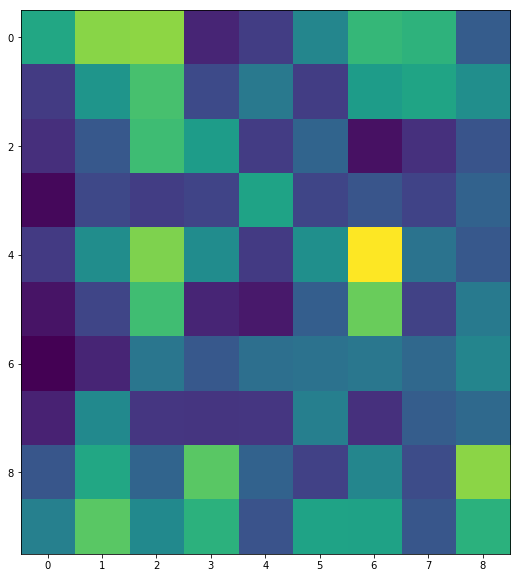

In [25]:
# CHECKING IMPACT OF LOWER LAYER
x,y = validation_generator[100]
y0 = M.predict(x)

i = M_Up.get_input_at(0)
o = M_Up.get_output_at(0)

Up_model = K.function([i],[o])

i1 = M_unet.get_input_at(0)
o1 = M_unet.get_output_at(0)

o2 = M_unet.get_layer('Reshape').output
o3 = M_unet.get_layer('elu_301').get_output_at(0)
o4 = M_unet.get_layer('Conv3_301').get_output_at(0)
o5 = M_unet.get_layer('Conv3_302').get_output_at(0)

Second_model = K.function( [i],[o1])
Dense_layer = K.function( [i1],[o2])
Antepen_layer = K.function( [i1],[o3])
Last_layer = K.function( [i1],[o4])

#img = Dense_layer(First_model([x]))[0]
img = Dense_layer(Up_model([x]))[0]
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
ax.imshow((np.mean(abs(img),axis=0).T))

In [29]:
#w0,w1 = M_unet.get_layer('Dense_1').get_weights()

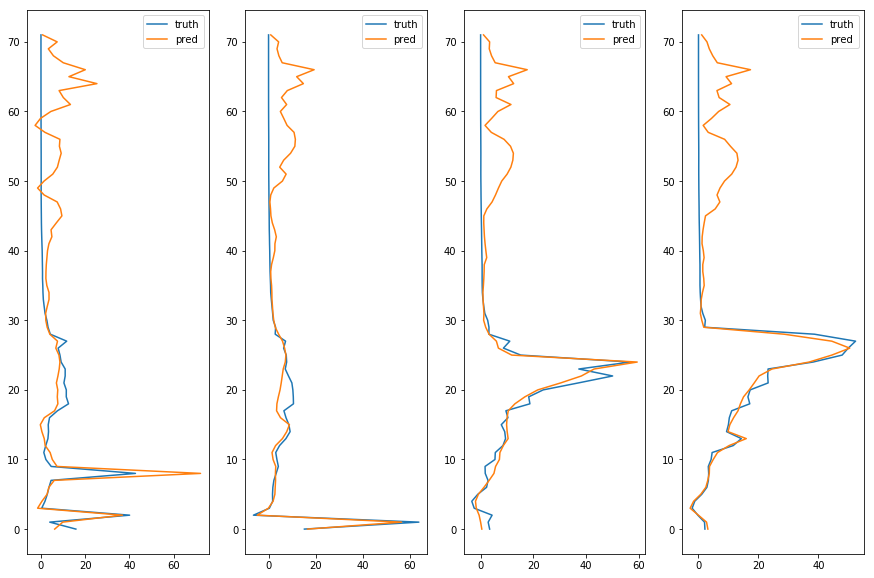

In [34]:
#i=np.random.randint(len(validation_generator))
x,y=validation_generator[i]
y0 = M.predict(x)
y0 = np.expand_dims(y0,axis=-1)
y = np.expand_dims(y,axis=-1)
J=np.arange(4)
Plot_diff( F_and_plots(shape=(1,len(J))), y,y0, header_y=['flx'], J=J)

In [ ]:
M.load_weights('BestModels/Best_Unet_[double_output]_4epochs')

x,y=validation_generator[i]
y0 = M.predict(x)
y0 = np.expand_dims(y0,axis=-1)
y = np.expand_dims(y,axis=-1)
J=np.arange(4)
Plot_diff( F_and_plots(shape=(1,len(J))), y,y0, header_y=['flx'], J=J)diff( F_and_plots(shape=(1,len(J))), y,y0, header_y=['flx'], J=J)